In [1]:
"""
Copyright 2022 Huawei Technologies Co., Ltd

CREATED:  2022-22-04 13:12:13
MODIFIED: 2022-12-20 08:48:45
"""

# -*- coding:utf-8 -*-
import cv2, sys
import numpy as np
import random as rnd
#
from PIL import Image, ImageDraw
from src.model import preprocessing
from src.postprocessing import non_max_suppression, scale_coords
# define acllite library path
sys.path.append('../../Common/acllite')
# modules of acllite library
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# define device id & model path
device_id = 0
model_path = "model/yolov5s6.om"

# define image & coco_names paths
img_path = "data/dog.jpg"
coco_names_path = "data/coco.names"

In [4]:
#load coco names
with open(coco_names_path) as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][0:]

In [5]:
# initialize acllite library
acl_resource = AclLiteResource()
acl_resource.init()
print('[Device] NPU Device id:',acl_resource.device_id)
# load *.om model
model = AclLiteModel(model_path)

init resource stage:
Init resource success
[Device] NPU Device id: 0
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 4335000
Create model output dataset success
Init model resource success


In [6]:
# read image
img_org_bgr = cv2.imread(img_path)

In [7]:
# 1) pre-processing stage
data, model_input_height, model_input_width, \
model_output_height, model_output_width = preprocessing(img_org_bgr,model._model_desc)

model input size 1
input  0
model input dims ({'name': 'images', 'dimCount': 4, 'dims': [1, 640, 640, 3]}, 0)
model input datatype 4
model output size 1
output  0
model output dims ({'name': 'Concat_404:0:output', 'dimCount': 3, 'dims': [1, 25500, 85]}, 0)
model output datatype 1
[Model] class Model init resource stage success
[PreProc] img_resized shape (640, 640, 3)


In [8]:
%timeit -n 10 -r 3
result_list = model.execute([data,]) # 2) model execution(forward) stage

In [9]:
# 3) post-processing the raw predictions
feature_maps =result_list[0].reshape(-1,model_output_height, model_output_width)
# apply non-maximum suppression to remove overlapping detections
pred = non_max_suppression(feature_maps, conf_thres=0.5, iou_thres=0.6, 
                        classes=None, agnostic=False)

# Process detections
bboxes = []

for i, det in enumerate(pred):  # detections per image
    # Rescale boxes from img_size to im0 size
    if det is not None:
        det[:, :4] = scale_coords((model_input_width, model_input_height), 
                    det[:, :4], img_org_bgr.shape).round()
        for *xyxy, conf, cls in det:
            bboxes.append([*xyxy, conf, int(cls)])
    else:
        pass

del feature_maps, result_list

In [10]:
# draw bounding boxes
img = Image.open(img_path)
img1 = ImageDraw.Draw(img)

for bbox in bboxes:
    label = coco_labels[int(bbox[5])]
    print(bbox[:4], bbox[4], bbox[5], label)

    color ="#FF"+''.join([rnd.choice('0123456789ABCDEF') for j in range(4)]) # random color for bounding boxes
    
    img1.rectangle(list(bbox[:4]), outline =color, width=3) # draw bounding boxes
    img1.rectangle((bbox[0], bbox[1], bbox[0] + len(label)*8, bbox[1] + 15), 
                outline = (255,255,255), width=10) # draw box for lable
    
    img1.text((bbox[0]+5, bbox[1]), label, (0,0,0), thickness=10)

[133.0, 226.0, 312.0, 542.0] 0.9135742 16 dog
[127.0, 128.0, 565.0, 425.0] 0.9135742 1 bicycle
[471.0, 75.0, 691.0, 171.0] 0.71728516 2 car


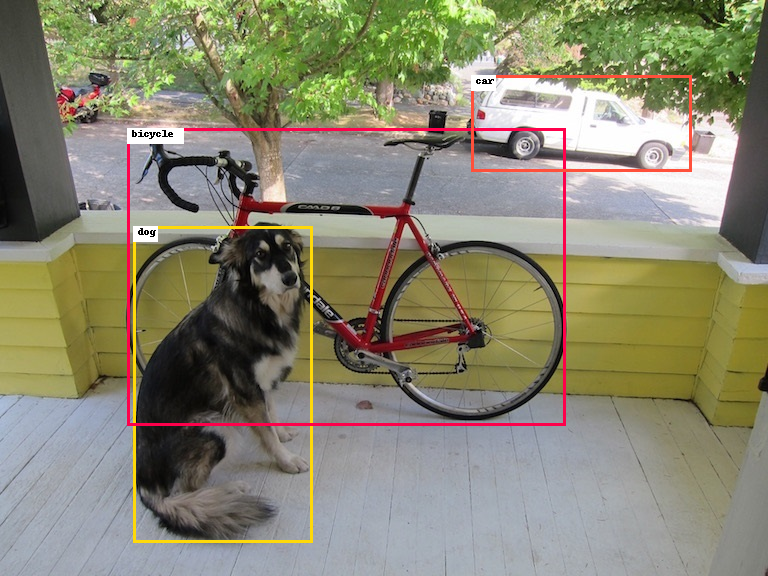

In [11]:
img